#Sentiment analysis on news headlines

The goal of this project is to test the hypothesized advantages of using and fine-tuning pre-trained language models of BERT (Bidirectional Encoder Representations from Transformers), which is a 2018 paper published by researchers at Google AI Language, for financial domain. For that, sentiment of a sentence from a financial news article towards the financial actor depicted in the sentence will be tried to be predicted, using the Financial PhraseBank created by Malo et al. from Cornell University. (2014)


# The models tested in this projects are as follows:


* A. Lexicon-based approach (Loughran and McDonald Dictionary) 
* B. Tfidf 
* C1. LSTM (RNN) 
* C2. LSTM with GloVe word embedding 
* D1. Bert (pre-trained, hugging-face impementation) 
* D2. Albert

##Import and Configrations

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB


True

In [ ]:
# Check the module versions
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cachetools                    5.3.0
cata

In [ ]:
# Note: After the following pip install, you may need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install scikit-plot transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.6 MB/s eta 0:00:00


Logging is a means of tracking events that happen when some software runs. Logging is important for software developing, debugging, and running. If you don’t have any logging record and your program crashes, there are very few chances that you detect the cause of the problem. And if you detect the cause, it will consume a lot of time. With logging, you can leave a trail of breadcrumbs so that if something goes wrong, we can determine the cause of the problem. 

In [ ]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys##It lets us access system-specific parameters and functions
import time
import logging
import random
import json
from collections import defaultdict, Counter
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
from sklearn.model_selection import KFold
# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##Check the version of the GPU

In [ ]:
import torch

In [ ]:
# Set logger
loggers = {}

def set_logger(name, level):
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        if (logger.hasHandlers()):
            logger.handlers.clear()
            
        logger.setLevel(level)

        timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
        formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

        fh = logging.FileHandler(name + '.log')
        # fh.setLevel(logging.DEBUG)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

        ch = logging.StreamHandler(sys.stdout)
        # ch.setLevel(level)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        
        loggers[name] = logger
        return logger

logger = set_logger('sa_model_comparison_tweet', logging.DEBUG)

In [ ]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [ ]:

# Mount Google Drive
# Enter the oauth code from the link
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import requests
import os
import pandas as pd
import zipfile
import matplotlib.pyplot as plt


In [ ]:
##  Fetch the data through out the API of FinancialPhraseBank-v1.0 in zip format then we unzip it or extract it......
r = requests.get("https://github.com/neoyipeng2018/FinancialPhraseBank-v1.0/raw/main/FinancialPhraseBank-v1.0.zip")
with open('FinancialPhraseBank-v1.0.zip', 'wb') as f: f.write(r.content)
with zipfile.ZipFile('FinancialPhraseBank-v1.0.zip', 'r') as zip_ref: zip_ref.extractall(os.getcwd())

In [ ]:
# Specify file locations
if IN_COLAB:
    finphrase_dir = 'drive/My Drive/Colab Data/'
    tweet_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    finphrase_dir = 'FinancialPhraseBank-v1.0/'
    tweet_dir = './data/tweet/'
    output_dir = './data/result/'
    lmdict_dir = './data/LoughranMcDonald/'
    glove_dir = './data/GloVe/'

In [ ]:
result_df = pd.DataFrame(columns=['Accuracy', 'F1'], index=['A: Lexicon', 'B: Tfidf', 'C1: LSTM'])
result_df

,Accuracy,F1
A: Lexicon,NaN,NaN
B: Tfidf,NaN,NaN
C1: LSTM,NaN,NaN


In [ ]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

##Load the Input Data of Stocktwits through out the API

In [ ]:
import json
import urllib.request

def save_file_if_missing(filename):
  if not os.path.exists(filename):
    response = load_file_from_external_source(filename)
    with open(filename, 'wb') as fp:
      fp.write(response.read())

def load_file_from_external_source(filename):
  if not os.path.exists(filename):
    URL = f'https://vkontech.com/post-sentiment-analysis/{filename}'
    request = urllib.request.Request(URL)
    # These headers are required as a workaround to download public files from Wordpress
    request.add_header('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36')
    resp = urllib.request.urlopen(request)
    return resp

def save_object_to_file(filename, content):
  with open(filename, 'wb') as fp:
      pickle.dump(content, fp)

def load_object_from_file(filename):
  with open(filename, 'rb') as fp:
    return pickle.load(fp)

In [ ]:
twits_filename = 'twits.json'
if not os.path.exists(twits_filename):
  response = load_file_from_external_source(twits_filename)
  twits = json.load(response)
  save_object_to_file(twits_filename, twits)
else:
  twits = load_object_from_file(twits_filename)
  twits["data"]=twits["data"][:80000]

twits['data'][:100]
# print(len(twits["data"]))

[{'message_body': '$FITB great buy at 26.00...ill wait',
  'sentiment': 2,
  'timestamp': '2018-07-01T00:00:09Z'},
 {'message_body': '@StockTwits $MSFT',
  'sentiment': 1,
  'timestamp': '2018-07-01T00:00:42Z'},
 {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating',
  'sentiment': 2,
  'timestamp': '2018-07-01T00:01:24Z'},
 {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.',
  'sentiment': 1,
  'timestamp': '2018-07-01T00:01:47Z'},
 {'message_body': '$AMD reveal yourself!',
  'sentiment': 0,
  'timestamp': '2018-07-01T00:02:13Z'},
 {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?',
  'sentiment': 1,
  'timestamp': '2018-07-01T00:03:10Z'},
 {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA',
  'sentiment

## Arrange the Datasets

In [ ]:
def load_tweet(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    print(twits['data'][:10])
    print("The number of twits is: ", len(twits['data']))
    messages = [twit['message_body'] for twit in twits['data']]
    # Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in the network
    sentiments = [twit['sentiment'] + 2 for twit in twits['data']]
    
    print('Sample Messages: \n', messages[:10])
    return messages, sentiments

# Load data
filename = 'twits.json'
messages, sentiments = load_tweet(filename)
print(len(messages)),print(len(sentiments))
messages=messages[:200000]
sentiments=sentiments[:200000]
print(len(messages)),print(len(sentiments))


[{'message_body': '$FITB great buy at 26.00...ill wait', 'sentiment': 2, 'timestamp': '2018-07-01T00:00:09Z'}, {'message_body': '@StockTwits $MSFT', 'sentiment': 1, 'timestamp': '2018-07-01T00:00:42Z'}, {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', 'sentiment': 2, 'timestamp': '2018-07-01T00:01:24Z'}, {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', 'sentiment': 1, 'timestamp': '2018-07-01T00:01:47Z'}, {'message_body': '$AMD reveal yourself!', 'sentiment': 0, 'timestamp': '2018-07-01T00:02:13Z'}, {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?', 'sentiment': 1, 'timestamp': '2018-07-01T00:03:10Z'}, {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', 'sentiment': -2, 'timestamp': '2018-07-01T

(None, None)

##Process Input Text

In [ ]:
def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message (Means we replace with spaces)
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)## sticker symbol
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)

    # Replace everything not a letter with a space
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    return text

In [ ]:
# Check
test_message = 'RT @google Our annual looked at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG'
print(preprocess(test_message))

rt   our annual looked at the year in google blogging  and beyond     


In [ ]:
# Process for all messages
#tqdm shows the progress bar, number of iterations, time taken to run the loop, and frequency of iterations per second
preprocessed = [preprocess(message) for message in tqdm(messages)]

  0%|          | 0/80000 [00:00<?, ?it/s]

##Explore the text

In [ ]:
all_words = [word for message in preprocessed for word in message.split()]
print('The number of all words: ', len(all_words))
counts = Counter(all_words)
print('The number of unique words: ', len(counts))

bow = sorted(counts, key=counts.get, reverse=True)
print('Top 40 frequent words: ', bow[:40])

The number of all words:  870249
The number of unique words:  23846
Top 40 frequent words:  ['the', 'to', 'for', 'is', 'a', 'on', 's', 'of', 'in', 'and', 'this', 'i', 'it', 'at', 'will', 'are', 'q', 'up', 'what', 'here', 'that', 'estimize', 'short', 'be', 'just', 'you', 'today', 'reporting', 'report', 'analysts', 'from', 't', 'with', 'not', 'was', 'new', 'buy', 'we', 'more', 'down']


In [ ]:
preprocessed[:10]

['  great buy at         ill wait',
 '   ',
 ' staanalystalert for     jefferies maintains with a rating of hold setting target price at usd         our own verdict is buy   ',
 '  i heard there s a guy who knows someone who thinks somebody knows something   on stocktwits ',
 '  reveal yourself ',
 '  why the drop  i warren buffet taking out his position ',
 '  bears have   reason on       to pay more attention  ',
 '  ok good we     re not dropping in price over the weekend  lol',
 '    daily chart  we need to get back to above    ',
 '     drop per week after spike    if no news in   months  back to   s    if bo  then bingo    what is the odds ']

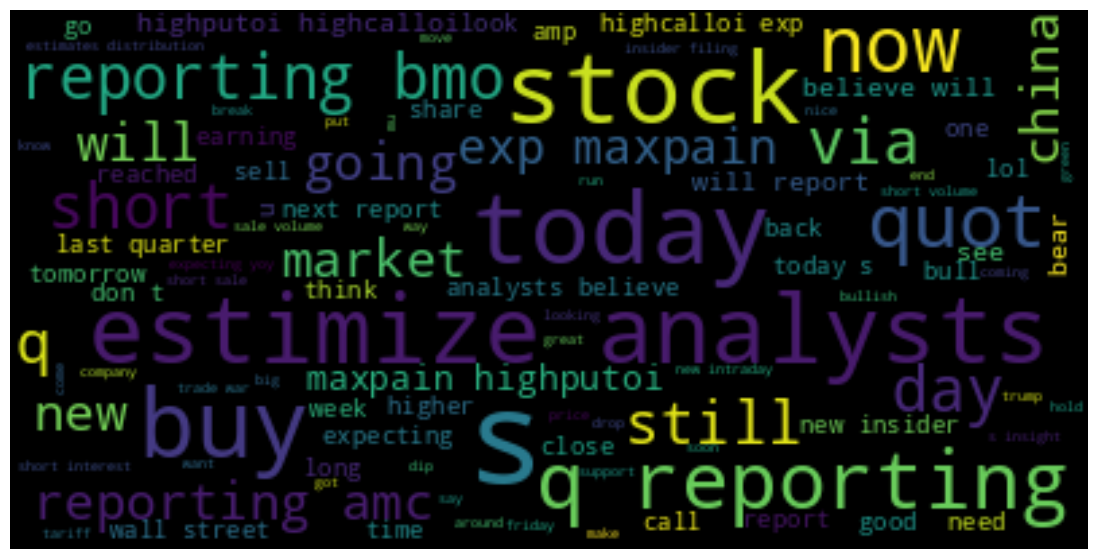

In [ ]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(all_words)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=None, max_font_size=50, max_words=100, background_color="black").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Construct the DataFrame

In [ ]:
tmp_dict = {'org message': messages, 'sentence': preprocessed, 'label': sentiments}
tmp_df = pd.DataFrame(tmp_dict)
print(len(tmp_df))
# Ignore tweets having less than 10 words
tmp_df = tmp_df.loc[tmp_df['sentence'].apply(lambda x: len(x.split())) >= 10]
tmp_df.reset_index(drop=True, inplace=True)

# Samples
pd.set_option('display.max_colwidth', -1)
tmp_df.sample(n=20, random_state=42)
print(len(tmp_df))

80000
42907


<ipython-input-206-d6ac666d73b2>:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


<ipython-input-207-398a5c8ee9fe>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([len(x) for x in tmp_df['sentence']])


<Axes: ylabel='Density'>

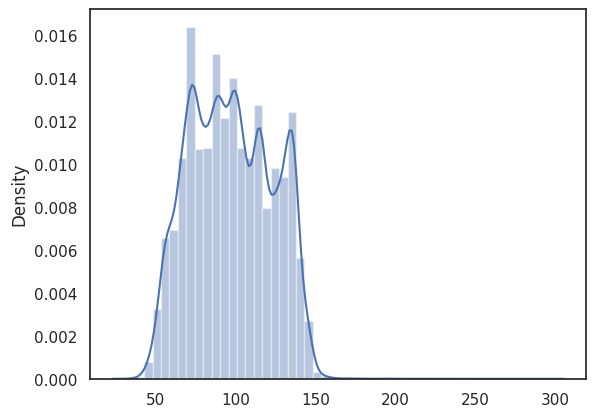

In [ ]:
## Ploting the distributions plot takes input as an array
sns.distplot([len(x) for x in tmp_df['sentence']])

## Data Selection

The total number of data:  80000


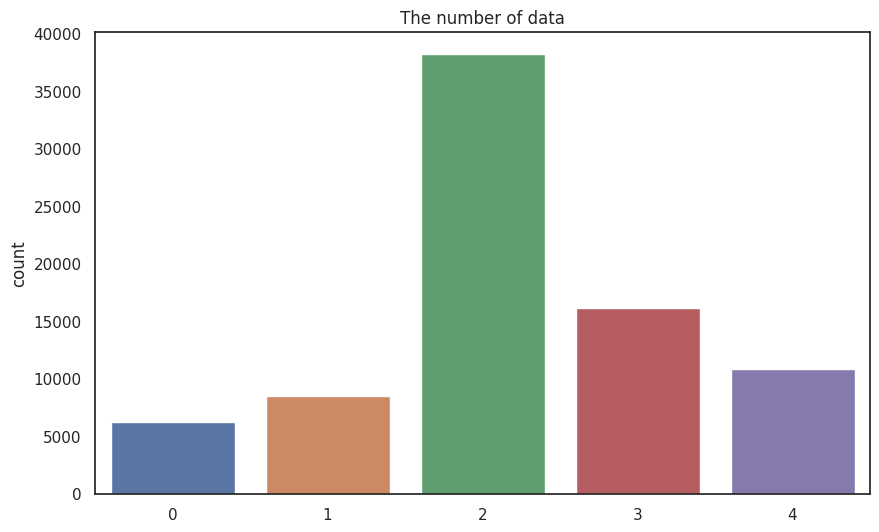

In [ ]:
## 2 = is neutral
print("The total number of data: ", len(sentiments))
plt.figure(figsize=(10,6))
sns.countplot(x=sentiments)
plt.title('The number of data')
plt.show()

More than 60% of the data are labeled as "neutral". Sometimes imbalanced data are balanced using methods like resampling (oversampling, undersampling) as models tend to predict the majority class more. SMOTE or the Synthetic Minority Over-sampling Technique is a popular technique for oversampling but it is a statistical method for numerical data.

Here, take label = 0, 2, 4 and balance the data using random down sampling method.

tqdm shows the progress bar, number of iterations, time taken to run the loop, and frequency of iterations per second.

## Balanced the data

In [ ]:

train_df = tmp_df.loc[(tmp_df['label']==int(0))|(tmp_df['label']==int(2))|(tmp_df['label']==int(4))]
train_df.head(10)

,org message,sentence,label
0,#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy http://www.stocktargetadvisor.com/toprating,staanalystalert for jefferies maintains with a rating of hold setting target price at usd our own verdict is buy,4
4,"$GME 3% drop per week after spike... if no news in 3 months, back to 12s... if BO, then bingo... what is the odds?",drop per week after spike if no news in months back to s if bo then bingo what is the odds,0
5,$SNPS short ratio is 2.17 at 2018-06-15 and short % to float is 1.42% http://sunshineavenue.com/stock/SNPS/ via @sunshineave,short ratio is at and short to float is via,0
6,"$NFLX price squeezing,perfect place for an option straddle near the supporting trend",price squeezing perfect place for an option straddle near the supporting trend,4
7,@DEEPAKM2013 @Nytunes Start of new Q on Monday. Expect strong buy volume across key companies of various sectors. $AMZN $AAPL,start of new q on monday expect strong buy volume across key companies of various sectors,4
8,$AMZN 3 catalysts 4 Continuing this new uptrend; #1- Pill Pack buy out #2- Amazon Prime Day #3- Earnings. Test/break of 1763 soon $SPY $QQQ,catalysts continuing this new uptrend pill pack buy out amazon prime day earnings test break of soon,4
9,$AAPL has moved -0.21% on 06-29. Check out the movement and peers at https://dividendbot.com?s=AAPL,has moved on check out the movement and peers at,2
10,#STAAnalystAlert for $TGT : MKM Partners Set Price Target with a rating of Buy setting target price at USD 91.00. Our own verdict is Buy http://www.stocktargetadvisor.com/toprating,staanalystalert for mkm partners set price target with a rating of buy setting target price at usd our own verdict is buy,4
13,The Current Ratio of $FSLR is much better than the industry average of 2.71. https://www.chartmill.com/analyze.php?utm_source=stocktwits&amp;utm_medium=FA&amp;utm_content=HEALTH&amp;utm_campaign=social_tracking#/FSLR?r=fa&amp;key=b431cf47-ec7e-4226-b864-511b6081b3be,the current ratio of is much better than the industry average of,2
15,"17 breakouts: $CAMP, $EEP (base), $ENB (gap and 200-day MA), $GBX, $HSBC, $NKE (gap), $RDHL, $VRTX (gap), $XLRN (gap and 200-day MA)",breakouts base gap and day ma gap gap gap and day ma,4


In [ ]:
# Take 0, 2, 4 and update them to 0, 1, 2
## In this steps we balanced our data and anything which u r think
train_df = tmp_df.loc[(tmp_df['label']==int(0))|(tmp_df['label']==int(2))|(tmp_df['label']==int(4))]
train_df=train_df[:60000]
def update_label(x):
    if x == int(2):
        return int(1)
    elif x == int(4):
        return int(2)
    else:
        return int(0)
train_df['label'] = train_df['label'].apply(lambda x: update_label(x))

# Balancing the data
n_negative = sum(1 for each in train_df['label'] if each == 0)
n_neutral = sum(1 for each in train_df['label'] if each == 1)
n_positive = sum(1 for each in train_df['label'] if each == 2)
N_examples = train_df.shape[0]

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Total records: ', N_examples)

balanced = {'org message': [], 'sentence': [], 'label': []}

# Keep probability
# As the negative has the least number of data=0, trim neutral and positive
keep_prob_neutral = n_negative/n_neutral
keep_prob_positive = n_negative/n_positive
#keep_prob = 1

for i, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    if row['sentence'].strip() == "":
        continue
    elif (row['label'] == 0) or ((row['label'] == 1) and (random.random() < keep_prob_neutral)) or ((row['label'] == 2) and (random.random() < keep_prob_positive)):
        balanced['org message'].append(row['org message'])
        balanced['sentence'].append(row['sentence'])
        balanced['label'].append(row['label'])

train_df = pd.DataFrame(balanced)

print(train_df[:5])
print("################################################################",len(train_df),"#####################################################")

n_negative = sum(1 for each in train_df['label'] if each == 0)
n_neutral = sum(1 for each in train_df['label'] if each == 1)
n_positive = sum(1 for each in train_df['label'] if each == 2)
N_examples = len(train_df)

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Total records: ', N_examples)

Negative: 0.12267491834278837
Neutral:  0.6620250988482035
Positive: 0.21529998280900808
Total records:  29085


  0%|          | 0/29085 [00:00<?, ?it/s]

                                                                                                                                   org message  \
0  $GME 3% drop per week after spike... if no news in 3 months, back to 12s... if BO, then bingo... what is the odds?                            
1  $SNPS short ratio is 2.17 at 2018-06-15 and short % to float is 1.42% http://sunshineavenue.com/stock/SNPS/ via @sunshineave                  
2  $NFLX price squeezing,perfect place for an option straddle near the supporting trend                                                          
3  @DEEPAKM2013 @Nytunes Start of new Q on Monday. Expect strong buy volume across key companies of various sectors. $AMZN $AAPL                 
4  $AMZN 3 catalysts 4 Continuing this new uptrend; #1- Pill Pack buy out #2- Amazon Prime Day #3- Earnings. Test/break of 1763 soon $SPY $QQQ   

                                                                                                                           

The total number of data:  10760


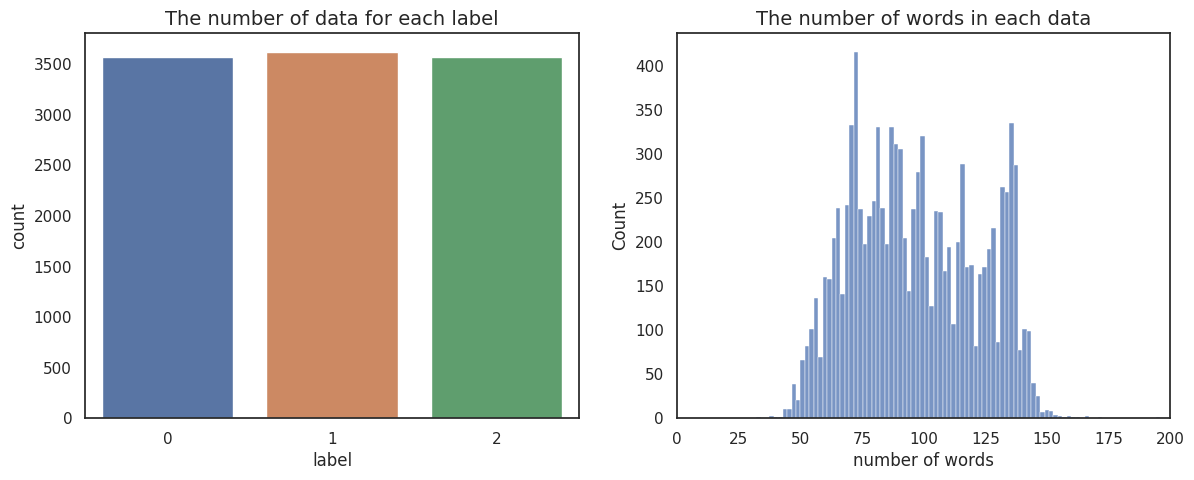

In [ ]:
print("The total number of data: ", len(train_df))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data for each label', fontsize=14)

sns.histplot([len(x) for x in train_df['sentence']], ax=ax2, bins=100)
ax2.set_title('The number of words in each data', fontsize=14)
ax2.set_xlim(0,200)
ax2.set_xlabel('number of words')
plt.show()


#A. Lexicon-based Approach
##Add sentiment based on Loughran and McDonald Sentiment Word Lists

The Lexicon-based approach determines polarity or sentiment to classify tweets in three different categories: Negative, Neutral, and Positive (Negative and Positive if desired)

In [ ]:
# Load sentiment data
sentiment_df = pd.read_csv('/content/drive/MyDrive/SA_Model_Comparison_Finphrase/LM-SA-2020.csv')

print(sentiment_df.shape)
sentiment_df

(9752, 2)


,word,sentiment
0,abandon,Negative
1,abandoned,Negative
2,abandoning,Negative
3,abandonment,Negative
4,abandonments,Negative
...,...,...
9747,record low,Negative
9748,record production,Positive
9749,on track,Positive
9750,back foot,Negative


In [ ]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()## First convert the words in lower case
sentiments = sentiment_df['sentiment'].unique()## takes non repeated elements
sentiment_df.groupby(by=['sentiment']).count()## and count how many times that comes basically the counter of the words
# print(len(sentiment_df))

,word
sentiment,
Constraining,432
Litigious,1630
Negative,5646
Positive,1231
StrongModal,19
Uncertainty,767
WeakModal,27


In [ ]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}
sentiment_dict

{'Negative': ['abandon',
  'abandoned',
  'abandoning',
  'abandonment',
  'abandonments',
  'abandons',
  'abdicated',
  'abdicates',
  'abdicating',
  'abdication',
  'abdications',
  'aberrant',
  'aberration',
  'aberrational',
  'aberrations',
  'abetting',
  'abnormal',
  'abnormalities',
  'abnormality',
  'abnormally',
  'abolish',
  'abolished',
  'abolishes',
  'abolishing',
  'abrogate',
  'abrogated',
  'abrogates',
  'abrogating',
  'abrogation',
  'abrogations',
  'abrupt',
  'abruptly',
  'abruptness',
  'absence',
  'absences',
  'absenteeism',
  'abuse',
  'abused',
  'abuses',
  'abusing',
  'abusive',
  'abusively',
  'abusiveness',
  'accident',
  'accidental',
  'accidentally',
  'accidents',
  'accusation',
  'accusations',
  'accuse',
  'accused',
  'accuses',
  'accusing',
  'acquiesce',
  'acquiesced',
  'acquiesces',
  'acquiescing',
  'acquit',
  'acquits',
  'acquittal',
  'acquittals',
  'acquitted',
  'acquitting',
  'adulterate',
  'adulterated',
  'adult

In [ ]:
# Consider Negation menas which have not or reverse of the themself
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())## basically search that substring which is similar to the r'---------' and return as as List 
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [ ]:
# Analyze tone for original text dataframe
print(train_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in tqdm(train_df['sentence'], total=train_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
train_tone_df = pd.concat([train_df, tone_lmdict_df.reindex(train_df.index)], axis=1)
train_tone_df.head()

(10760, 3)


  0%|          | 0/10760 [00:00<?, ?it/s]

,org message,sentence,label,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,"$GME 3% drop per week after spike... if no news in 3 months, back to 12s... if BO, then bingo... what is the odds?",drop per week after spike if no news in months back to s if bo then bingo what is the odds,0,-4.761905,21,0,1,[],[drop]
1,$SNPS short ratio is 2.17 at 2018-06-15 and short % to float is 1.42% http://sunshineavenue.com/stock/SNPS/ via @sunshineave,short ratio is at and short to float is via,0,-20.000000,10,0,2,[],"[short, short]"
2,"$NFLX price squeezing,perfect place for an option straddle near the supporting trend",price squeezing perfect place for an option straddle near the supporting trend,2,8.333333,12,3,2,"[perfect, near, supporting]","[place, trend]"
3,@DEEPAKM2013 @Nytunes Start of new Q on Monday. Expect strong buy volume across key companies of various sectors. $AMZN $AAPL,start of new q on monday expect strong buy volume across key companies of various sectors,2,6.250000,16,2,1,"[strong, various]",[buy]
4,$AMZN 3 catalysts 4 Continuing this new uptrend; #1- Pill Pack buy out #2- Amazon Prime Day #3- Earnings. Test/break of 1763 soon $SPY $QQQ,catalysts continuing this new uptrend pill pack buy out amazon prime day earnings test break of soon,2,-5.882353,17,1,2,[prime],"[buy, out]"


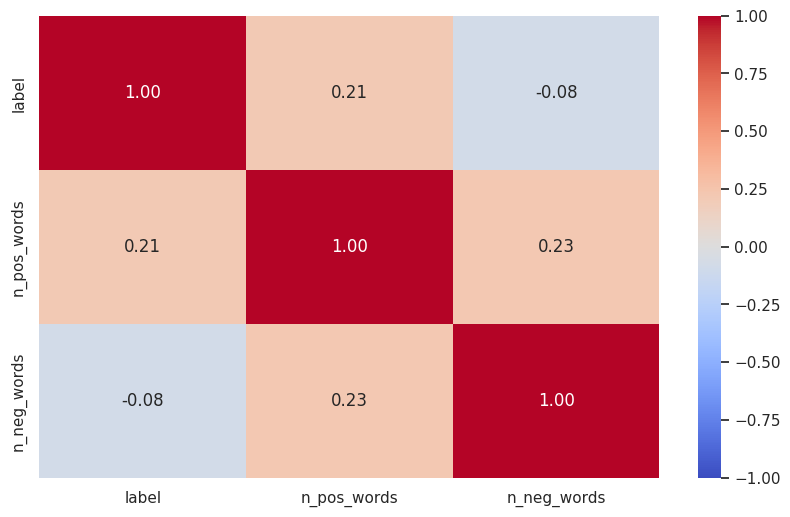

In [ ]:
# Show corelations to next_decision
plt.figure(figsize=(10,6))
#corr_columns = ['label', 'tone_score', 'word_count', 'n_pos_words', 'n_neg_words']
corr_columns = ['label', 'n_pos_words', 'n_neg_words']
sns.heatmap(train_tone_df[corr_columns].astype(float).corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.show()

In [ ]:
##Input data
train_tone_df.columns

Index(['org message', 'sentence', 'label', 'tone_score', 'word_count',
       'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words'],
      dtype='object')

In [ ]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = train_tone_df[['tone_score', 'n_pos_words', 'n_neg_words']]
# Y_data=Y_data[:20000]
# X_data=X_data[:20000]
print(Y_data.shape,X_data.shape)
# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

(10760,) (10760, 3)


##Train with different classifier

In [ ]:
# Roughly check base classifiers without hyperparameter setting

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

random_state = 2
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state, n_estimators=100)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))

classifiers


[('SVC', SVC(random_state=2)),
 ('DecisionTree', DecisionTreeClassifier(random_state=2)),
 ('AdaBoost',
  AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=2),
                     learning_rate=0.1, random_state=2)),
 ('RandomForest', RandomForestClassifier(random_state=2)),
 ('ExtraTrees', ExtraTreesClassifier(random_state=2)),
 ('GradientBoosting', GradientBoostingClassifier(random_state=2)),
 ('MultipleLayerPerceptron', MLPClassifier(random_state=2)),
 ('KNeighboors', KNeighborsClassifier(n_neighbors=3)),
 ('LogisticRegression', LogisticRegression(random_state=2)),
 ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
 ('GaussianNB', GaussianNB()),
 ('Perceptron', Perceptron()),
 ('LinearSVC', LinearSVC()),
 ('SGD', SGDClassifier())]

In [ ]:
pd.DataFrame([rec[0] for rec in classifiers])

,0
0,SVC
1,DecisionTree
2,AdaBoost
3,RandomForest
4,ExtraTrees
5,GradientBoosting
6,MultipleLayerPerceptron
7,KNeighboors
8,LogisticRegression
9,LinearDiscriminantAnalysis


##Train with Grid Search Cross Validation

In [ ]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys##It lets us access system-specific parameters and functions
import time
import logging
import random
import json
from collections import defaultdict, Counter
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
from sklearn.model_selection import KFold
# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
from sklearn.metrics import accuracy_score
# from sklearn.metrics import plot_confusion_matrix

In [ ]:
# Train and visualisation Function

def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
    

    return model

In [ ]:
# Use Random Forest Classifier

rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [1, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 5],
              'max_features': [1, 2, 3],
              'max_depth': [None],
              'criterion': ['gini'],

              'bootstrap': [False]}

# Do not use cross validation
nocv=[(slice(None), slice(None))]

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=nocv, verbose=0, plot=True)
rf_best = rf_model.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

Best Score:  0.559388385761815
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 46}
[2023-04-29 07:16:55,434][INFO] ## Training - acc: 0.55994424, f1: 0.55913187


INFO:sa_model_comparison_tweet:Training - acc: 0.55994424, f1: 0.55913187


[2023-04-29 07:16:55,444][INFO] ## Test - acc: 0.48884758, f1: 0.48645057


INFO:sa_model_comparison_tweet:Test - acc: 0.48884758, f1: 0.48645057


## Results

The prediction is not good at all. Hyper parameter tuning of Random Forest could not beat the simple model of Linear Discriminant Analysis. Confusion matrix shows almost all the data have been labeled as "neutral", the majority class.

In [ ]:
pred_test = rf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['A: Lexicon'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,0.4888,0.4865
B: Tfidf,NaN,NaN
C1: LSTM,NaN,NaN


Text(0.5, 1.0, 'Feature importance')

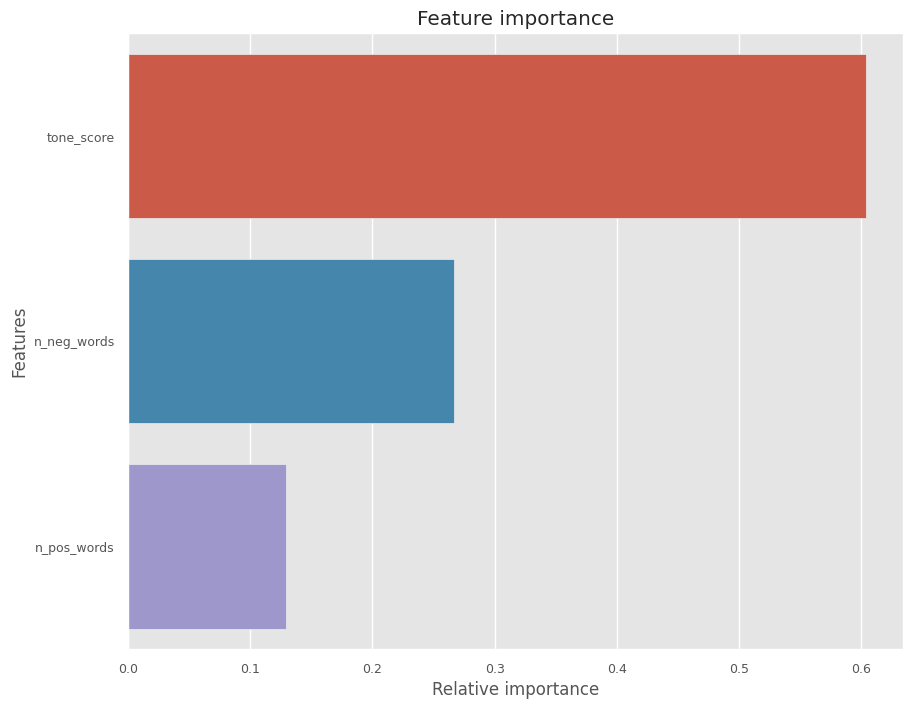

In [ ]:
# Which features is important Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")

TfidfVectorizer - Transforms text to feature vectors that can be used as input to estimator.

#B.Tfidf

###Tokenizer

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    Mode:
        1: NLTK word_tokenize(), Stop words removal, Alphabet only, Lemmetize
        2: NLTK word_tokenize(), Stop words removal, Alphabet only, Do not lemmetize
        3: NLTK word_tokenize(), Do not remove stop words, Alphabet only, Do not lemmetize
        4: (alphabet + "'s" + "'t")

    '''
    tokenized = []
    for text in tqdm(df[col]):
        # Filter alphabet words only , make it loser case
        if tokenizer=='NLTK':
            words = [word.lower() for word in word_tokenize(text) if (word.isalpha()==1)]
        else:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())

        # Remove stop words
        if stopwords:
             words = [word for word in words if (word not in stop)]
        # Lemmatize words
        if lemma:
            tokens = [lemmatize_word(word) for word in words]
            tokenized.append(tokens)
        else:
            tokenized.append(words)

    # Concat the list to create docs
    tokenized_text = [" ".join(words) for words in tokenized]

    # Create a list of all the words in the dataframe
    all_words = [word for text in tokenized for word in text]

    # Counter object of all the words
    counts = Counter(all_words)

    # Create a Bag of Word, sorted by the count of words
    bow = sorted(counts, key=counts.get, reverse=True)

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    # Create token id list
    token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

    return tokenized, tokenized_text, bow, vocab, id2vocab, token_ids

##Tokenise the Input Text

In [ ]:
# Lemmatize sentiment (not used)

pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

lemma_sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,271
Litigious,1231
Negative,5560
Positive,1129
StrongModal,15
Uncertainty,612


  0%|          | 0/10760 [00:00<?, ?it/s]

<ipython-input-144-0fa018f2e5d2>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([len(x) for x in tokenized_text])


<Axes: ylabel='Density'>

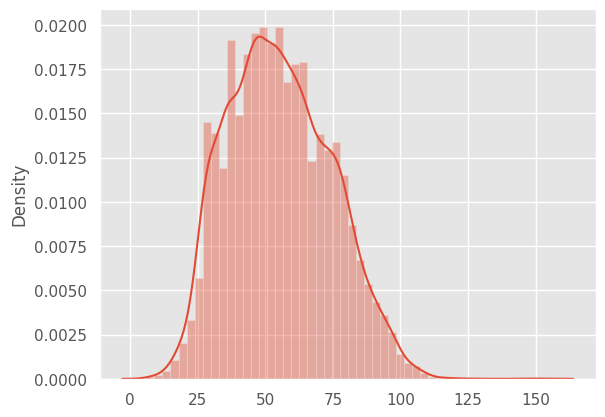

In [ ]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK')
sns.distplot([len(x) for x in tokenized_text])

In [ ]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = tokenized_text
print(Y_data.shape)
print(len(X_data))

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_data, Y_data.values, test_size=0.2, shuffle=True)
# print(X_train)
# print(Y_train)
# print(X_test)
# print(Y_test)

(10760,)
10760


##Model and Train (Logistic Regression)

In [ ]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', LogisticRegression())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[2023-04-29 07:16:59,314][INFO] ## Training - acc: 0.92077138, f1: 0.92068204


INFO:sa_model_comparison_tweet:Training - acc: 0.92077138, f1: 0.92068204


[2023-04-29 07:16:59,327][INFO] ## Test - acc: 0.81830855, f1: 0.81842129


INFO:sa_model_comparison_tweet:Test - acc: 0.81830855, f1: 0.81842129


## Model and Train (Random Forest)

In [ ]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2023-04-29 07:17:10,266][INFO] ## Training - acc: 0.99756041, f1: 0.99755905


INFO:sa_model_comparison_tweet:Training - acc: 0.99756041, f1: 0.99755905


[2023-04-29 07:17:10,274][INFO] ## Test - acc: 0.81737918, f1: 0.81767049


INFO:sa_model_comparison_tweet:Test - acc: 0.81737918, f1: 0.81767049


In [ ]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

# Do not use cross validation
nocv=[(slice(None), slice(None))]

# Perform Grid Search
param_grid = {'clf__n_estimators': [10, 50, 100, 150, 200],
              'clf__min_samples_leaf': [1, 2],
              'clf__min_samples_split': [4, 6],
              'clf__max_features': ['auto']
             }

tfidf_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=nocv, verbose=1, plot=True)
tfidf_best = tfidf_model.best_estimator_

Fitting 1 folds for each of 20 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Score:  0.9974423162310057
Best Param:  {'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 100}
[2023-04-29 07:19:17,646][INFO] ## Training - acc: 0.99744424, f1: 0.99744232


INFO:sa_model_comparison_tweet:Training - acc: 0.99744424, f1: 0.99744232


[2023-04-29 07:19:17,654][INFO] ## Test - acc: 0.82434944, f1: 0.82453015


INFO:sa_model_comparison_tweet:Test - acc: 0.82434944, f1: 0.82453015


##Result

Much better than lexicon approach. Apparently it overfitting to the training set.

In [ ]:
pred_test = tfidf_best.predict(X_test)
acc, f1 = metric(Y_test, pred_test)
result_df.loc['B: Tfidf'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,0.4888,0.4865
B: Tfidf,0.8536,0.8536
C1: LSTM,NaN,NaN


#C1. LSTM (RNN)
* Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

* LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

* All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

* LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

In [ ]:
# Import Pytorch modules
# import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, AdamW

##Tokenise input texts

  0%|          | 0/10760 [00:00<?, ?it/s]

<ipython-input-151-e02b3c9ba6f3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([len(x) for x in tokenized_text])


<Axes: ylabel='Density'>

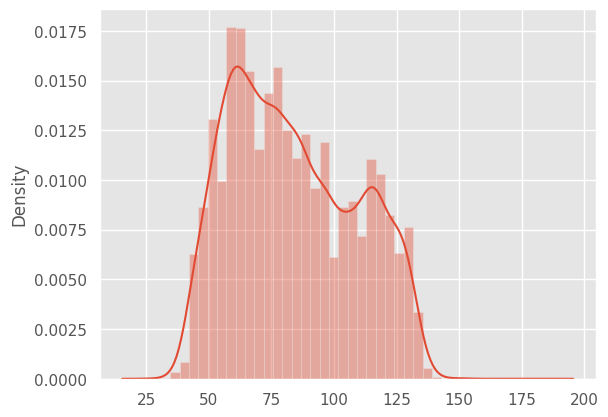

In [ ]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_df, col='sentence', lemma=False, stopwords=False, tokenizer='Own')
sns.distplot([len(x) for x in tokenized_text])

In [ ]:
# X and Y data used
y_data = train_tone_df['label']
X_data = token_ids

# Train test split (Shuffle=False will make the test data for the most recent ones)
# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_data, y_data.values, test_size=0.2, shuffle=True)

##Define Model

#####Embed -> RNN -> Dense -> Softmax


In [ ]:
from torch import nn
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=2, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.dense_size = dense_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)

        if dense_size == 0:
            self.fc = nn.Linear(lstm_size, output_size)
        else:
            self.fc1 = nn.Linear(lstm_size, dense_size)
            self.fc2 = nn.Linear(dense_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        if self.dense_size == 0:
            out = self.fc(lstm_out)
        else:
            dense_out = self.fc1(lstm_out)
            out = self.fc2(dense_out)
        # Softmax
        logps = self.softmax(out)

        return logps, hidden_state

##DataLoaders and Batching

Here, I used own dataloader. It's also fine to use tensorflow/keras or pytorch implementation.

In [ ]:
def dataloader(messages, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

In [ ]:
# Test the model
text_batch, labels = next(iter(dataloader(X_train, y_train)))
lstm_model = TextClassifier(len(vocab), 512, 128, 8, 3)
hidden = lstm_model.init_hidden(16)
logps, hidden = lstm_model.forward(text_batch, hidden)
print(logps)

tensor([[-1.5158, -0.9816, -0.9022],
        [-1.4883, -0.9863, -0.9131],
        [-1.4811, -0.9874, -0.9162],
        [-1.4939, -0.9716, -0.9238],
        [-1.4958, -0.9845, -0.9105],
        [-1.4839, -0.9759, -0.9254],
        [-1.5163, -0.9612, -0.9212],
        [-1.4810, -0.9885, -0.9152],
        [-1.4977, -0.9669, -0.9261],
        [-1.5098, -0.9712, -0.9152],
        [-1.4899, -0.9784, -0.9196],
        [-1.4989, -0.9920, -0.9019],
        [-1.5025, -0.9849, -0.9065],
        [-1.4679, -1.0154, -0.8981],
        [-1.5047, -0.9765, -0.9131],
        [-1.4810, -1.0004, -0.9042]], grad_fn=<LogSoftmaxBackward0>)


##Configure the model and train!

In [ ]:
# Define the training process

def train_lstm_model(lstm_model, X_train, y_train, X_valid, y_valid, epochs, batch_size, learning_rate, sequence_length, patience, clip, print_every, print_epoch):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize Model
    lstm_model.embedding.weight.data.uniform_(-1, 1)
    lstm_model.to(device)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    lstm_model.train()

    # Initialise
    accuracy = []
    f1_score = []
    best_f1, early_stop = 0, 0
    
    class_names = ['Negative', 'Neutral', 'Positive']


    # Validation steup
    def do_vadalition(valid_hidden):
        lstm_model.eval()
        valid_losses = []
        y_predicted = []
        y_truth = []
       

        for text_batch, labels in dataloader(
                X_valid, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state
            valid_hidden = tuple([each.data for each in valid_hidden])

            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in valid_hidden:
                each.to(device)

            # Get output and hidden state from the model
            valid_output, _ = lstm_model(text_batch, valid_hidden)

            # Calculate the loss     
            valid_loss = criterion(valid_output.squeeze(), labels)
            valid_losses.append(valid_loss.item())

            # Prediction
            ps = torch.exp(valid_output)
            top_p, top_class = ps.topk(1, dim=1)

            y_predicted.extend(top_class.squeeze().cpu().numpy())
            y_truth.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

        lstm_model.train()

        return y_truth, y_predicted, valid_losses

    # Training cycle
    for epoch in tqdm(range(epochs), desc="Epochs"):
        print('Starting epoch {}'.format(epoch + 1))
        hidden = lstm_model.init_hidden(batch_size)
        steps = 0

        for text_batch, labels in dataloader(
                X_train, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            optimizer.zero_grad()
            lstm_model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = lstm_model(text_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                y_truth, y_predicted, valid_losses = do_vadalition(hidden)
                acc, f1 = metric(y_truth, y_predicted)
                print("Epoch: {}/{}".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))

        # End of epoch evaluation
        y_truth, y_predicted, valid_losses = do_vadalition(hidden)
        acc, f1 = metric(y_truth, y_predicted)
        
        if print_epoch:
            print("Completed {} steps in epoch {}".format(steps, epoch+1))
            

            # Plot Confusion Matrix
            y_truth_class = [class_names[int(idx)] for idx in y_truth]
            y_predicted_class = [class_names[int(idx)] for idx in y_predicted]
            
            titles_options = [("Actual Count", None), ("Normalised", 'true')]
            for title, normalize in titles_options:
                disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title)
            plt.show()

            print("\nEpoch: %d, Accuracy: %.8f, F1: %.8f\n" % (epoch+1, acc, f1))

        # If not improving, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
        else:
            early_stop += 1
                
        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

    # Post process
    y_truth, y_predicted, valid_losses = do_vadalition(hidden)
    acc, f1 = metric(y_truth, y_predicted)
    print("Completed all epochs")
    print("Accuracy: %.8f, F1: %.8f" % (acc, f1))

    return acc, f1

In [ ]:
# Set Hyperparameters

# for Training
epochs=5
batch_size=64
learning_rate=3e-4
sequence_length=96
dropout=0.1
patience=3
clip=5
print_every=1000
print_epoch=True

# Model parameters
embed_size=512
lstm_size=128
dense_size=0
lstm_layers=2

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Starting epoch 1
Completed 135 steps in epoch 1


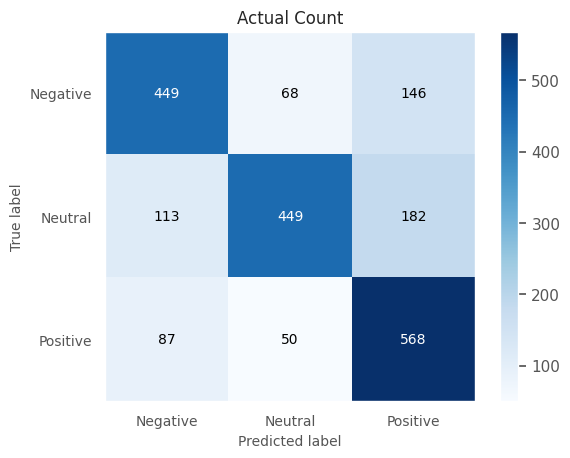

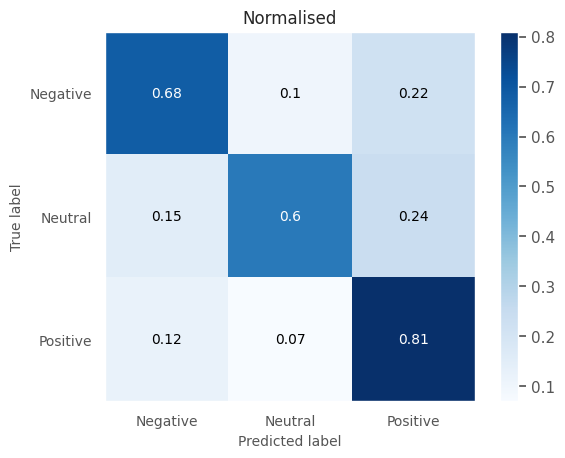


Epoch: 1, Accuracy: 0.69412879, F1: 0.69299368

Starting epoch 2
Completed 135 steps in epoch 2


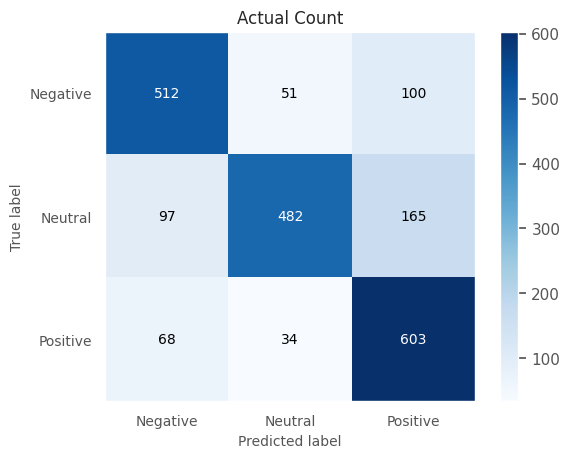

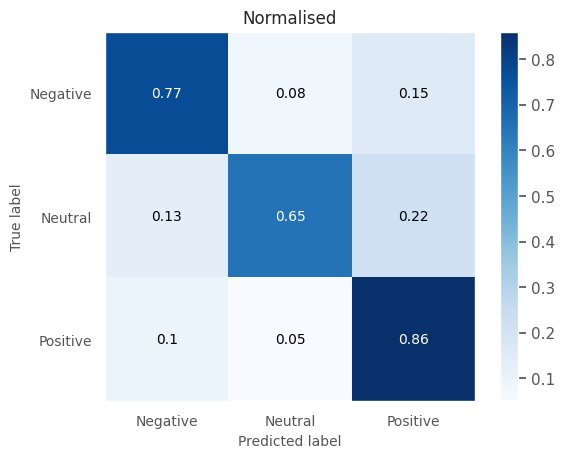


Epoch: 2, Accuracy: 0.75615530, F1: 0.75539450

Starting epoch 3
Completed 135 steps in epoch 3


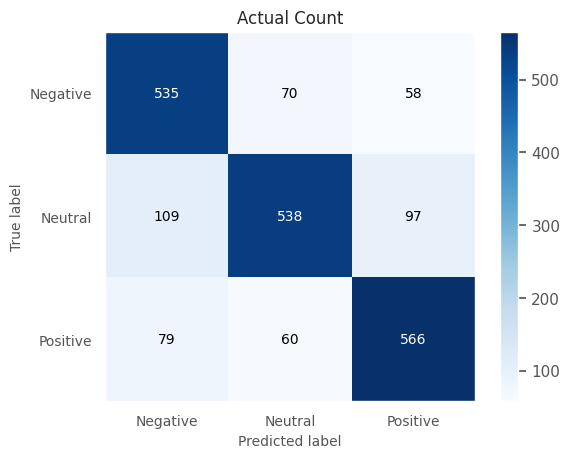

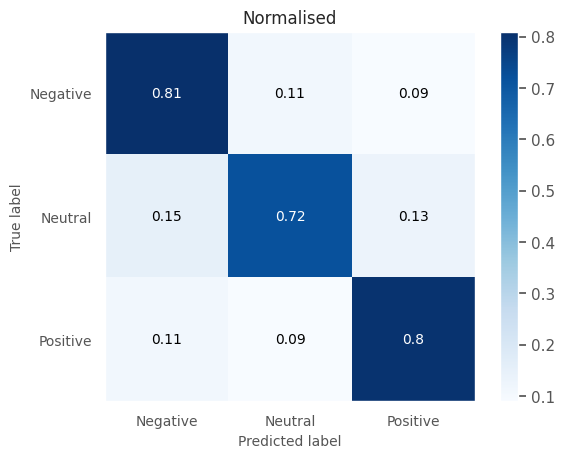


Epoch: 3, Accuracy: 0.77604167, F1: 0.77595811

Starting epoch 4
Completed 135 steps in epoch 4


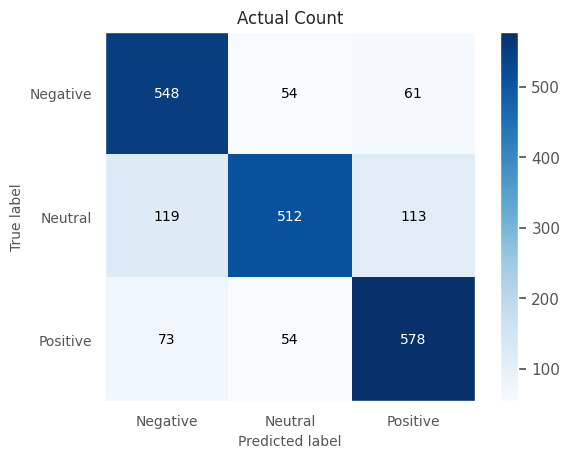

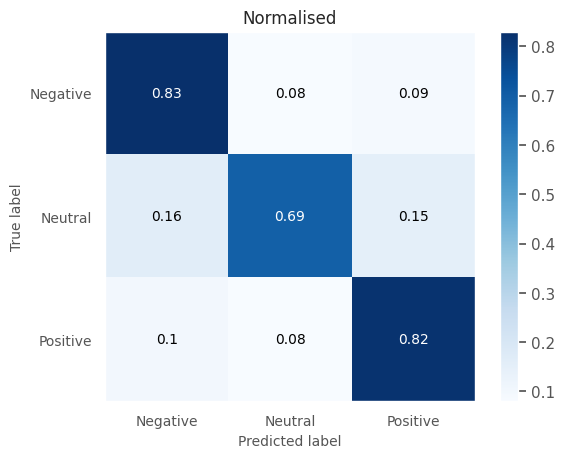


Epoch: 4, Accuracy: 0.77556818, F1: 0.77510915

Starting epoch 5
Completed 135 steps in epoch 5


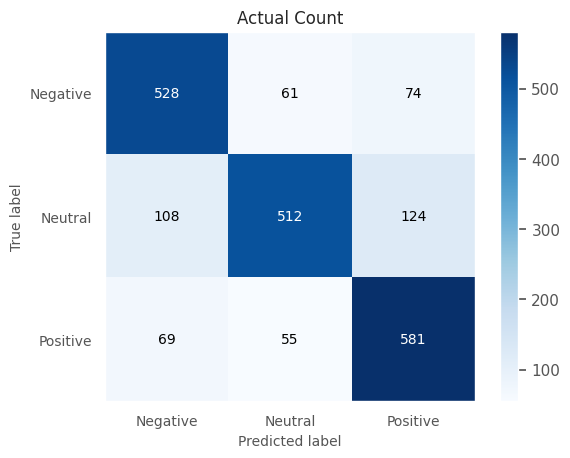

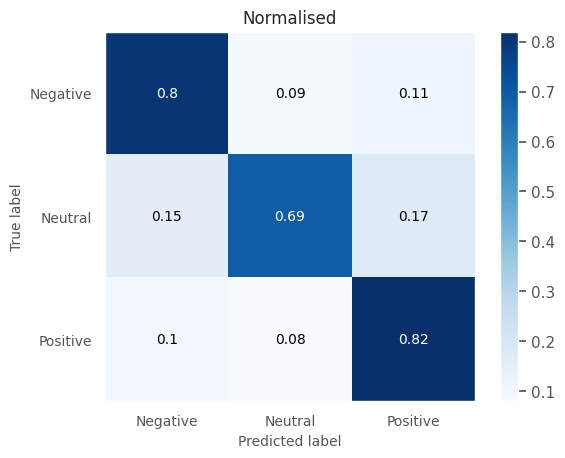


Epoch: 5, Accuracy: 0.76751894, F1: 0.76710146

Completed all epochs
Accuracy: 0.76751894, F1: 0.76710146


In [ ]:
# Re-train the model with all Train set and validate on Test set

# Set Model
model = TextClassifier(len(vocab)+1, embed_size, lstm_size, dense_size, 3, lstm_layers, dropout)

acc, f1 = train_lstm_model(model, X_train, y_train, X_test, y_test, \
                         epochs, batch_size, learning_rate, sequence_length, \
                         patience, clip, print_every, print_epoch)
        

In [ ]:
result_df.loc['C1: LSTM'] = (round(acc,4), round(f1,4))
result_df

,Accuracy,F1
A: Lexicon,0.4888,0.4865
B: Tfidf,0.8536,0.8536
C1: LSTM,0.7675,0.7671
C2: LSTM,0.7675,0.7671


## Final Results

In [ ]:
# If disconnected after the training complete, just recreate the result_df rather than running the training again...
disconnected = False
if disconnected:
    result_df = pd.DataFrame(columns=['Accuracy', 'F1'], index=['A: Lexicon', 'B: Tfidf', 'C: LSTM'])
    result_df.loc['A: Lexicon'] = (0.4888,0.4865)
    result_df.loc['B: Tfidf'] = (0.8536,0.8536)
    result_df.loc['C1: LSTM'] = (0.7675,0.7671)
    

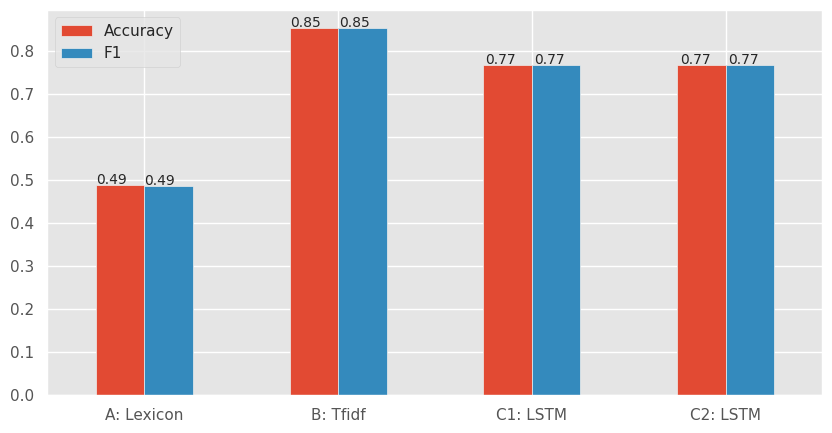

In [ ]:
ax = result_df.plot.bar(rot=0, figsize=(10,5))

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

## Save Model

In [ ]:
# Save Data
def save_data(df, file_name, dir_name=output_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save text data
save_data(train_df, 'tweet_result_df')

In [ ]:
# 'twits.json'

In [ ]:
## Check the model evaluations
with open('/content/drive/MyDrive/Semantic_dataset_segmentation/Twitter dataset/test_twits.json', 'r') as f:
    test_data = json.load(f)

def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

{'message_body': '$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN',
 'timestamp': '2018-11-01T00:00:05Z'}

In [ ]:
def predict(text, model, tokenizer):
    """ 
    Make a prediction on a single sentence.

    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.

    Returns
    -------
        pred : Prediction vector
    """   
    text = preprocess(text)
    inputs = tokenizer(text, 
                   return_tensors="pt", 
                   padding='max_length',
                   max_length=96,
                   add_special_tokens=True,
                   truncation=True)

    outputs = model(**inputs)[0].detach()    
    pred = F.softmax(outputs, dim=1)
    
    return pred

##Load and saving the best model 

In [ ]:
# Save
torch.save(tfidf_model, "/content/drive/MyDrive/Semantic_dataset_segmentation/Twitter dataset/model.pt")
# Load
model = torch.load("/content/drive/MyDrive/Semantic_dataset_segmentation/Twitter dataset/model.pt")